In [1]:
# from tensorflow.python.client import device_lib
# local_device_protos = device_lib.list_local_devices()
# print([x.name for x in local_device_protos])

In [2]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
params = {
    'lr': 0.001,
    'beta1': 0.5,
    'num_epochs': 500,
    'image_dim': 28*28*3, 
    'hidden_dim': 512, 
    'latent_dim': 2, 
    'seed': 3333, 
    'batch_size': 128,
    'gen_size': 25
}

# Build dataset

In [4]:
input_dir = 'inputs/img_align_celeba'
input_names = [os.path.join(input_dir, f) for f in os.listdir(input_dir)]
num_inputs = len(input_names)

In [5]:
# Testing
#input_names[:5]

In [6]:
# Testing
# img = plt.imread(input_names[1])
# img.shape

In [7]:
from PIL import Image
def transform(image_name):
    image = Image.open(image_name)    
    image_width, image_height = image.size[0], image.size[1]
    face_width = face_height = 108
    
    j = (image_width - face_width)//2
    i = (image_height - face_height)//2
    image = image.crop((j, i, j+face_width, i+face_height))
    image = image.resize([28, 28], Image.BILINEAR)
    image = np.array(image.getdata())
    
    min_image = 0
    max_image = 255
    image_transformed = (image - min_image)/(max_image - min_image)
    #print(image_transformed.shape)
    
    image_flatten = image_transformed.astype(np.float32).ravel()
    #print(image_flatten.shape)

    return image_flatten

In [8]:
# images_flatten = []
# num = len(input_names)
# for idx, name in enumerate(input_names):
#     image_flatten = transform(name)
#     images_flatten.append(image_flatten)
#     if idx % 10000 == 0 :
#         print("%d/%d images done"%(idx, num))
# images_flatten = np.array(images_flatten)
# np.save('images_flatten.npy', images_flatten)

In [9]:
data = np.load("images_flatten.npy") 
data_placeholder = tf.placeholder(data.dtype, data.shape)
dataset = tf.contrib.data.Dataset.from_tensor_slices(data_placeholder)
dataset = dataset.shuffle(buffer_size=10000)
dataset = dataset.batch(params['batch_size'])
dataset = dataset.repeat(params['num_epochs'])
print(dataset.output_shapes)

(?, 2352)


In [10]:
# if transform was done by batch, gpu will not be used

# train_names_tf = tf.constant(input_names)
# trainset = tf.contrib.data.Dataset.from_tensor_slices(train_names_tf)
# trainset = trainset.map(lambda filename: tf.py_func(transform, [filename], [tf.float32]))
# trainset = trainset.shuffle(buffer_size=10000)
# trainset = trainset.batch(params['batch_size'])
# trainset = trainset.repeat(params['num_epochs'])

# Build model

In [11]:
class VAE():
    def __init__(self, params=params, is_train=True):
        
        self.params = params
        self.is_train = is_train
        self.initializer = tf.contrib.layers.xavier_initializer()
            
    def encoder(self, image_input):
        
        with tf.variable_scope("encoder"):
            W_encoder = tf.get_variable('W_encoder', shape=[self.params['image_dim'], self.params['hidden_dim']], initializer=self.initializer)
            b_encoder = tf.get_variable('b_encoder', shape=[self.params['hidden_dim']], initializer=self.initializer)

            W_z_mean = tf.get_variable('W_z_mean', shape=[self.params['hidden_dim'], self.params['latent_dim']], initializer=self.initializer)
            b_z_mean = tf.get_variable('b_z_mean', shape=[self.params['latent_dim']], initializer=self.initializer)
        
            W_z_std = tf.get_variable('W_z_std', shape=[self.params['hidden_dim'], self.params['latent_dim']], initializer=self.initializer)
            b_z_std = tf.get_variable('b_z_std', shape=[self.params['latent_dim']], initializer=self.initializer)  

            
            encoder = tf.matmul(image_input, W_encoder) + b_encoder    
            encoder = tf.nn.tanh(encoder) 
            
            z_mean = tf.matmul(encoder, W_z_mean) + b_z_mean           
            z_std = tf.matmul(encoder, W_z_std) + b_z_std  
            eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')
            z = z_mean + tf.exp(z_std / 2) * eps
            
        return z, z_mean, z_std
                
    def decoder(self, z): 
        
        with tf.variable_scope("decoder", reuse = not self.is_train):
            W_decoder = tf.get_variable('W_decoder', shape=[self.params['latent_dim'], self.params['hidden_dim']], initializer=self.initializer)
            b_decoder = tf.get_variable('b_decoder', shape=[self.params['hidden_dim']], initializer=self.initializer)
        
            W_decoder_out = tf.get_variable('W_z_decoder_out', shape=[self.params['hidden_dim'], self.params['image_dim']], initializer=self.initializer)
            b_decoder_out = tf.get_variable('b_z_decoder_out', shape=[self.params['image_dim']], initializer=self.initializer)      

            decoded = tf.matmul(z, W_decoder) + b_decoder
            decoded = tf.nn.tanh(decoded)
                        
            decoded = tf.matmul(decoded, W_decoder_out) + b_decoder_out
            image_decoded = tf.nn.sigmoid(decoded)
            #print("decoded shape: ", image_decoded.shape)
            
        return image_decoded
    
    def forward(self, image_input):
        
        z, z_mean, z_std = self.encoder(image_input)
        image_decoded = self.decoder(z)
        
        return image_decoded, z_mean, z_std
    
    def create_loss(self, image_input, image_decoded, z_mean, z_std):
              
        with tf.name_scope('loss'):    
            encode_decode_loss = image_input * tf.log(1e-10 + image_decoded) + (1 - image_input) * tf.log(1e-10 + 1 - image_decoded)
            encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
            
            kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
            kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)            

            loss = tf.reduce_mean(encode_decode_loss + kl_div_loss)
            
        return loss  
    
    def create_optimizer(self, loss):
        
        with tf.name_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=params['lr'], beta1=params['beta1'])
            train_op = optimizer.minimize(loss)
        
        return train_op
    
    def create_summary(self, loss):
        
        with tf.name_scope("summaries"):
            summary_op = tf.summary.scalar("train_loss", loss)
        
        return summary_op
        
    def train(self):
        
        self.train_input = tf.placeholder(tf.float32, shape=(None, 28*28*3))       
        image_decoded, z_mean, z_std = self.forward(self.train_input)

        train_loss = self.create_loss(self.train_input, image_decoded, z_mean, z_std)
        train_op = self.create_optimizer(train_loss)
        train_summary_op = self.create_summary(train_loss)

        return train_op, train_loss, train_summary_op 
    
    def generate(self):
        
        self.is_train = False
        self.gen_input = tf.placeholder(tf.float32, shape=(None, self.params['latent_dim']))
        output = self.decoder(self.gen_input)
        
        return output

# Train model

In [12]:
log_dir = "log"
train_model_path = "model/train"
decoder_path = "model/decoder"

In [13]:
def display_images(images):
    fig = plt.figure()
    for idx, image in enumerate(images):
        image = image.reshape(28, 28, 3)
        ax = fig.add_subplot(5, 5, idx+1)
        #plt.subplots_adjust(wspace=0.01, hspace=0.01)
        ax.set_axis_off()
        ax.imshow(image)
    plt.show() # this line make sure the image is loaded to console before executing next line of code

In [14]:
with tf.device('/gpu:0'):
    tf.set_random_seed(params['seed'])
    model = VAE()
    train_op, train_loss, train_summary_op = model.train()
    #saver = tf.train.Saver()
    init = tf.global_variables_initializer()
    iterator = dataset.make_initializable_iterator()
    next_batch = iterator.get_next()

Epoch 0, train_loss: 1457.343018, running_time: 7


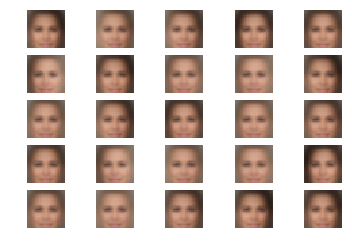

Epoch 1, train_loss: 1447.911743, running_time: 7
Epoch 2, train_loss: 1441.580200, running_time: 7
Epoch 3, train_loss: 1438.326294, running_time: 8
Epoch 4, train_loss: 1436.713623, running_time: 7
Epoch 5, train_loss: 1435.087769, running_time: 7
Epoch 6, train_loss: 1434.214111, running_time: 7
Epoch 7, train_loss: 1433.090332, running_time: 8
Epoch 8, train_loss: 1431.948730, running_time: 7
Epoch 9, train_loss: 1431.954712, running_time: 7
Epoch 10, train_loss: 1431.301270, running_time: 7


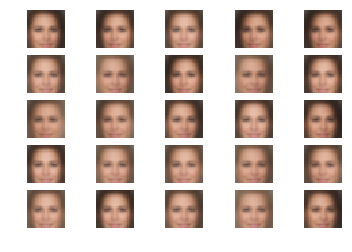

Epoch 11, train_loss: 1430.910645, running_time: 8
Epoch 12, train_loss: 1430.410889, running_time: 7
Epoch 13, train_loss: 1429.708740, running_time: 7
Epoch 14, train_loss: 1429.357056, running_time: 7
Epoch 15, train_loss: 1429.387695, running_time: 7
Epoch 16, train_loss: 1429.102539, running_time: 7
Epoch 17, train_loss: 1428.738525, running_time: 7
Epoch 18, train_loss: 1430.284302, running_time: 7
Epoch 19, train_loss: 1428.688843, running_time: 7
Epoch 20, train_loss: 1428.260864, running_time: 7


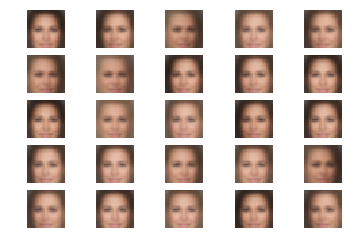

Epoch 21, train_loss: 1427.893188, running_time: 7
Epoch 22, train_loss: 1427.690796, running_time: 7
Epoch 23, train_loss: 1427.314941, running_time: 8
Epoch 24, train_loss: 1427.267212, running_time: 7
Epoch 25, train_loss: 1429.608643, running_time: 7
Epoch 26, train_loss: 1430.284912, running_time: 7
Epoch 27, train_loss: 1428.229980, running_time: 7
Epoch 28, train_loss: 1428.014893, running_time: 7
Epoch 29, train_loss: 1427.183472, running_time: 7
Epoch 30, train_loss: 1426.662354, running_time: 7


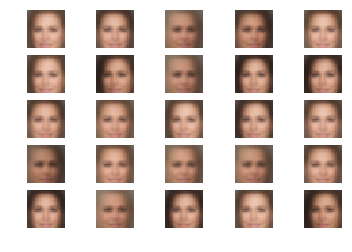

Epoch 31, train_loss: 1426.506592, running_time: 7
Epoch 32, train_loss: 1426.385010, running_time: 7
Epoch 33, train_loss: 1425.992432, running_time: 7
Epoch 34, train_loss: 1425.893921, running_time: 7
Epoch 35, train_loss: 1425.710571, running_time: 7
Epoch 36, train_loss: 1425.392944, running_time: 7
Epoch 37, train_loss: 1425.325195, running_time: 7
Epoch 38, train_loss: 1425.269531, running_time: 7
Epoch 39, train_loss: 1424.938110, running_time: 7
Epoch 40, train_loss: 1424.914185, running_time: 7


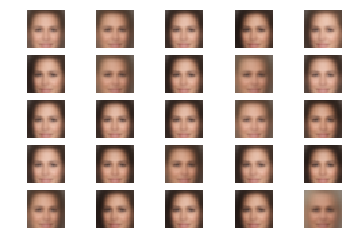

Epoch 41, train_loss: 1424.647461, running_time: 7
Epoch 42, train_loss: 1424.538696, running_time: 7
Epoch 43, train_loss: 1424.526489, running_time: 7
Epoch 44, train_loss: 1424.248291, running_time: 7
Epoch 45, train_loss: 1424.374390, running_time: 7
Epoch 46, train_loss: 1424.213379, running_time: 7
Epoch 47, train_loss: 1424.075439, running_time: 7
Epoch 48, train_loss: 1424.078369, running_time: 7
Epoch 49, train_loss: 1424.042603, running_time: 7
Epoch 50, train_loss: 1424.019287, running_time: 7


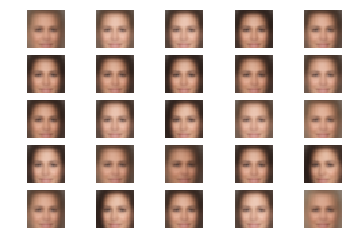

Epoch 51, train_loss: 1423.647705, running_time: 7
Epoch 52, train_loss: 1423.512939, running_time: 7
Epoch 53, train_loss: 1423.602661, running_time: 7
Epoch 54, train_loss: 1423.383911, running_time: 7
Epoch 55, train_loss: 1423.480713, running_time: 7
Epoch 56, train_loss: 1423.588257, running_time: 7
Epoch 57, train_loss: 1423.154785, running_time: 7
Epoch 58, train_loss: 1423.188599, running_time: 7
Epoch 59, train_loss: 1423.035645, running_time: 7
Epoch 60, train_loss: 1422.977783, running_time: 6


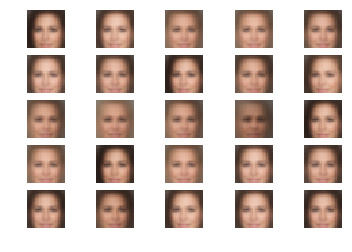

Epoch 61, train_loss: 1422.962280, running_time: 7
Epoch 62, train_loss: 1422.750610, running_time: 7
Epoch 63, train_loss: 1422.906494, running_time: 7
Epoch 64, train_loss: 1422.767700, running_time: 7
Epoch 65, train_loss: 1422.920288, running_time: 7
Epoch 66, train_loss: 1423.019287, running_time: 7
Epoch 67, train_loss: 1423.096436, running_time: 7
Epoch 68, train_loss: 1422.848022, running_time: 7
Epoch 69, train_loss: 1422.981323, running_time: 7
Epoch 70, train_loss: 1422.647217, running_time: 7


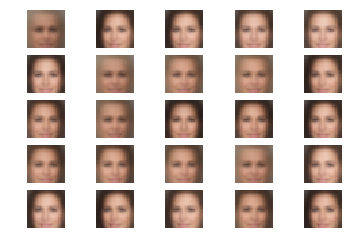

Epoch 71, train_loss: 1422.559326, running_time: 7
Epoch 72, train_loss: 1422.524292, running_time: 7
Epoch 73, train_loss: 1422.608521, running_time: 7
Epoch 74, train_loss: 1422.501587, running_time: 7
Epoch 75, train_loss: 1422.162231, running_time: 7
Epoch 76, train_loss: 1422.394775, running_time: 7
Epoch 77, train_loss: 1422.339233, running_time: 7
Epoch 78, train_loss: 1422.319702, running_time: 7
Epoch 79, train_loss: 1422.346802, running_time: 7
Epoch 80, train_loss: 1421.931641, running_time: 7


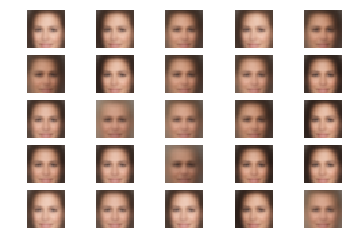

Epoch 81, train_loss: 1424.270996, running_time: 7
Epoch 82, train_loss: 1422.578491, running_time: 7
Epoch 83, train_loss: 1423.337280, running_time: 7
Epoch 84, train_loss: 1422.860718, running_time: 7
Epoch 85, train_loss: 1422.367188, running_time: 7
Epoch 86, train_loss: 1422.352539, running_time: 7
Epoch 87, train_loss: 1422.581177, running_time: 7
Epoch 88, train_loss: 1422.103271, running_time: 7
Epoch 89, train_loss: 1422.740967, running_time: 7
Epoch 90, train_loss: 1423.238525, running_time: 7


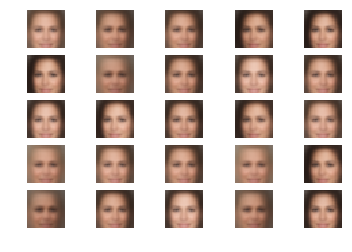

Epoch 91, train_loss: 1423.028687, running_time: 7
Epoch 92, train_loss: 1422.618652, running_time: 7
Epoch 93, train_loss: 1422.594727, running_time: 7
Epoch 94, train_loss: 1422.234741, running_time: 7
Epoch 95, train_loss: 1422.473999, running_time: 7
Epoch 96, train_loss: 1422.449341, running_time: 7
Epoch 97, train_loss: 1422.316284, running_time: 7
Epoch 98, train_loss: 1422.436890, running_time: 7
Epoch 99, train_loss: 1422.006348, running_time: 7
Epoch 100, train_loss: 1422.009766, running_time: 7


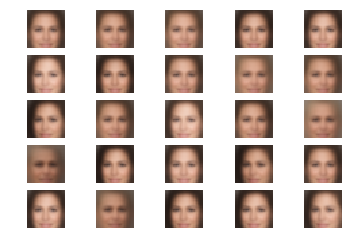

Epoch 101, train_loss: 1422.383179, running_time: 7
Epoch 102, train_loss: 1421.916870, running_time: 7
Epoch 103, train_loss: 1421.887207, running_time: 7
Epoch 104, train_loss: 1421.817749, running_time: 7
Epoch 105, train_loss: 1421.616821, running_time: 7
Epoch 106, train_loss: 1421.648438, running_time: 7
Epoch 107, train_loss: 1421.655396, running_time: 7
Epoch 108, train_loss: 1421.547729, running_time: 7
Epoch 109, train_loss: 1421.473755, running_time: 7
Epoch 110, train_loss: 1421.568237, running_time: 7


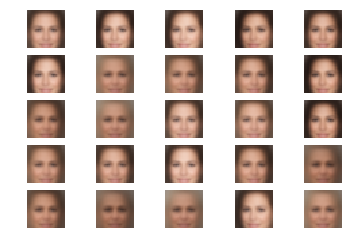

Epoch 111, train_loss: 1421.738770, running_time: 7
Epoch 112, train_loss: 1421.649292, running_time: 7
Epoch 113, train_loss: 1421.327393, running_time: 7
Epoch 114, train_loss: 1421.262451, running_time: 7
Epoch 115, train_loss: 1421.233765, running_time: 7
Epoch 116, train_loss: 1421.422485, running_time: 7
Epoch 117, train_loss: 1421.457886, running_time: 7
Epoch 118, train_loss: 1421.345093, running_time: 7
Epoch 119, train_loss: 1421.182617, running_time: 7
Epoch 120, train_loss: 1421.421631, running_time: 7


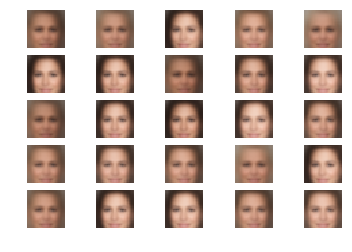

Epoch 121, train_loss: 1421.097412, running_time: 7
Epoch 122, train_loss: 1421.405518, running_time: 7
Epoch 123, train_loss: 1421.067749, running_time: 7
Epoch 124, train_loss: 1421.475098, running_time: 7
Epoch 125, train_loss: 1421.071411, running_time: 7
Epoch 126, train_loss: 1420.966187, running_time: 7
Epoch 127, train_loss: 1420.961182, running_time: 7
Epoch 128, train_loss: 1421.026245, running_time: 7
Epoch 129, train_loss: 1420.891602, running_time: 7
Epoch 130, train_loss: 1420.985107, running_time: 7


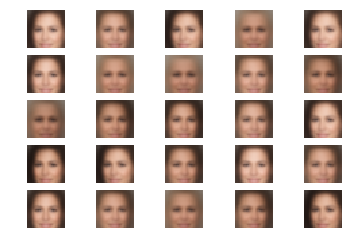

Epoch 131, train_loss: 1421.505737, running_time: 7
Epoch 132, train_loss: 1421.382812, running_time: 7
Epoch 133, train_loss: 1421.220093, running_time: 7
Epoch 134, train_loss: 1420.702637, running_time: 7
Epoch 135, train_loss: 1420.726196, running_time: 7
Epoch 136, train_loss: 1420.666138, running_time: 7
Epoch 137, train_loss: 1420.635010, running_time: 7
Epoch 138, train_loss: 1420.662476, running_time: 7
Epoch 139, train_loss: 1420.441284, running_time: 7
Epoch 140, train_loss: 1420.717896, running_time: 7


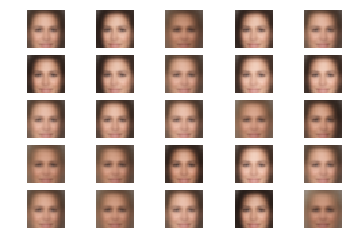

Epoch 141, train_loss: 1420.522705, running_time: 7
Epoch 142, train_loss: 1420.600098, running_time: 7
Epoch 143, train_loss: 1420.659668, running_time: 7
Epoch 144, train_loss: 1420.464966, running_time: 7
Epoch 145, train_loss: 1420.326538, running_time: 7
Epoch 146, train_loss: 1420.409302, running_time: 7
Epoch 147, train_loss: 1420.549561, running_time: 7
Epoch 148, train_loss: 1420.423584, running_time: 7
Epoch 149, train_loss: 1420.658447, running_time: 7
Epoch 150, train_loss: 1420.482666, running_time: 7


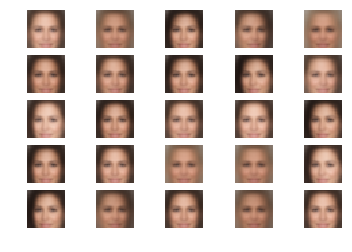

Epoch 151, train_loss: 1420.757935, running_time: 8
Epoch 152, train_loss: 1420.118774, running_time: 7
Epoch 153, train_loss: 1420.290283, running_time: 7
Epoch 154, train_loss: 1420.135498, running_time: 7
Epoch 155, train_loss: 1420.296875, running_time: 7
Epoch 156, train_loss: 1419.865601, running_time: 7
Epoch 157, train_loss: 1419.921997, running_time: 7
Epoch 158, train_loss: 1419.632446, running_time: 7
Epoch 159, train_loss: 1419.988037, running_time: 7
Epoch 160, train_loss: 1420.008667, running_time: 7


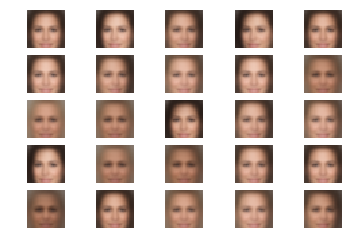

Epoch 161, train_loss: 1420.033447, running_time: 7
Epoch 162, train_loss: 1419.998535, running_time: 7
Epoch 163, train_loss: 1419.716675, running_time: 7
Epoch 164, train_loss: 1419.682739, running_time: 7
Epoch 165, train_loss: 1419.591064, running_time: 7
Epoch 166, train_loss: 1419.830688, running_time: 7
Epoch 167, train_loss: 1419.924683, running_time: 7
Epoch 168, train_loss: 1419.555542, running_time: 7
Epoch 169, train_loss: 1419.895020, running_time: 7
Epoch 170, train_loss: 1420.123535, running_time: 7


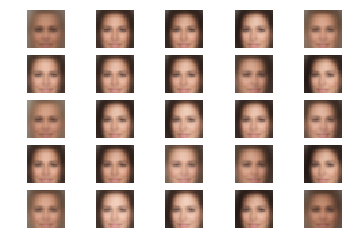

Epoch 171, train_loss: 1419.848389, running_time: 7
Epoch 172, train_loss: 1420.152710, running_time: 7
Epoch 173, train_loss: 1419.747925, running_time: 7
Epoch 174, train_loss: 1419.731079, running_time: 7
Epoch 175, train_loss: 1419.655396, running_time: 7
Epoch 176, train_loss: 1419.886353, running_time: 7
Epoch 177, train_loss: 1419.383789, running_time: 7
Epoch 178, train_loss: 1419.580200, running_time: 7
Epoch 179, train_loss: 1419.291748, running_time: 7
Epoch 180, train_loss: 1419.767578, running_time: 7


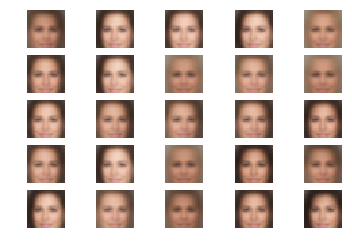

Epoch 181, train_loss: 1420.275757, running_time: 7
Epoch 182, train_loss: 1420.088745, running_time: 7
Epoch 183, train_loss: 1419.523682, running_time: 7
Epoch 184, train_loss: 1419.553101, running_time: 7
Epoch 185, train_loss: 1419.524536, running_time: 7
Epoch 186, train_loss: 1419.237793, running_time: 7
Epoch 187, train_loss: 1419.327271, running_time: 7
Epoch 188, train_loss: 1419.558716, running_time: 7
Epoch 189, train_loss: 1419.302490, running_time: 7
Epoch 190, train_loss: 1418.962402, running_time: 7


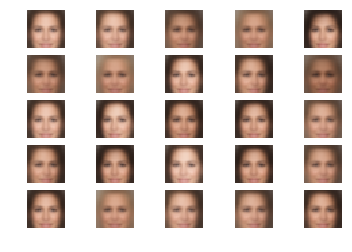

Epoch 191, train_loss: 1419.498901, running_time: 7
Epoch 192, train_loss: 1419.036133, running_time: 7
Epoch 193, train_loss: 1419.193359, running_time: 7
Epoch 194, train_loss: 1418.831665, running_time: 7
Epoch 195, train_loss: 1419.122559, running_time: 7
Epoch 196, train_loss: 1419.046631, running_time: 7
Epoch 197, train_loss: 1419.436646, running_time: 7
Epoch 198, train_loss: 1418.964966, running_time: 7
Epoch 199, train_loss: 1419.295532, running_time: 7
Epoch 200, train_loss: 1418.924683, running_time: 7


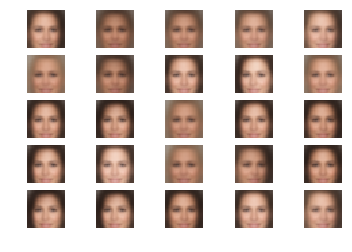

Epoch 201, train_loss: 1418.850342, running_time: 7
Epoch 202, train_loss: 1421.496216, running_time: 7
Epoch 203, train_loss: 1420.352783, running_time: 7
Epoch 204, train_loss: 1420.052246, running_time: 7
Epoch 205, train_loss: 1419.301636, running_time: 7
Epoch 206, train_loss: 1419.657959, running_time: 7
Epoch 207, train_loss: 1419.625610, running_time: 7
Epoch 208, train_loss: 1418.942017, running_time: 7
Epoch 209, train_loss: 1419.124146, running_time: 7
Epoch 210, train_loss: 1419.214478, running_time: 7


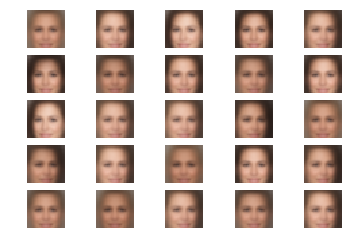

Epoch 211, train_loss: 1419.188599, running_time: 7
Epoch 212, train_loss: 1419.057617, running_time: 7
Epoch 213, train_loss: 1419.042969, running_time: 7
Epoch 214, train_loss: 1418.729614, running_time: 7
Epoch 215, train_loss: 1418.741333, running_time: 7
Epoch 216, train_loss: 1418.740234, running_time: 7
Epoch 217, train_loss: 1418.711182, running_time: 7
Epoch 218, train_loss: 1418.578979, running_time: 7
Epoch 219, train_loss: 1418.687988, running_time: 7
Epoch 220, train_loss: 1418.610718, running_time: 7


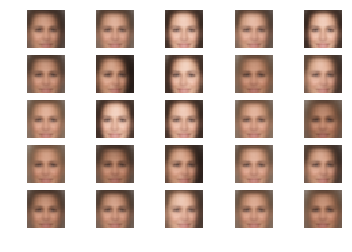

Epoch 221, train_loss: 1418.240967, running_time: 7
Epoch 222, train_loss: 1418.469727, running_time: 7
Epoch 223, train_loss: 1419.662354, running_time: 7
Epoch 224, train_loss: 1418.598877, running_time: 7
Epoch 225, train_loss: 1418.676758, running_time: 7
Epoch 226, train_loss: 1418.804443, running_time: 7
Epoch 227, train_loss: 1418.886353, running_time: 7
Epoch 228, train_loss: 1418.726807, running_time: 7
Epoch 229, train_loss: 1418.616699, running_time: 7
Epoch 230, train_loss: 1418.712280, running_time: 7


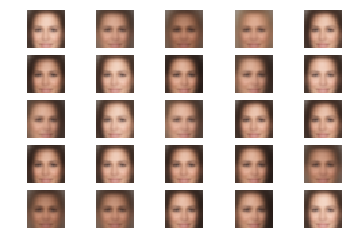

Epoch 231, train_loss: 1418.575317, running_time: 7
Epoch 232, train_loss: 1418.347778, running_time: 7
Epoch 233, train_loss: 1418.817017, running_time: 7
Epoch 234, train_loss: 1418.344116, running_time: 7
Epoch 235, train_loss: 1418.678101, running_time: 7
Epoch 236, train_loss: 1418.807129, running_time: 7
Epoch 237, train_loss: 1418.600098, running_time: 7
Epoch 238, train_loss: 1419.009033, running_time: 7
Epoch 239, train_loss: 1418.641357, running_time: 7
Epoch 240, train_loss: 1418.453857, running_time: 7


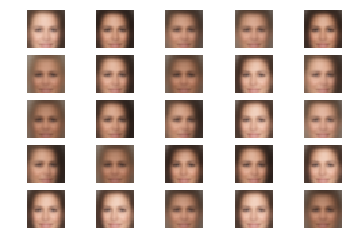

Epoch 241, train_loss: 1418.119751, running_time: 7
Epoch 242, train_loss: 1419.139282, running_time: 7
Epoch 243, train_loss: 1418.489258, running_time: 7
Epoch 244, train_loss: 1418.708740, running_time: 7
Epoch 245, train_loss: 1418.446289, running_time: 7
Epoch 246, train_loss: 1418.262207, running_time: 7
Epoch 247, train_loss: 1418.041016, running_time: 7
Epoch 248, train_loss: 1418.100342, running_time: 7
Epoch 249, train_loss: 1418.074829, running_time: 7
Epoch 250, train_loss: 1418.144165, running_time: 7


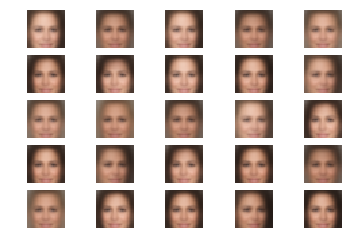

Epoch 251, train_loss: 1418.012451, running_time: 7
Epoch 252, train_loss: 1418.062500, running_time: 7
Epoch 253, train_loss: 1417.916016, running_time: 7
Epoch 254, train_loss: 1417.919312, running_time: 7
Epoch 255, train_loss: 1418.290161, running_time: 7
Epoch 256, train_loss: 1417.734009, running_time: 7
Epoch 257, train_loss: 1418.508545, running_time: 7
Epoch 258, train_loss: 1418.042480, running_time: 7
Epoch 259, train_loss: 1418.862183, running_time: 7
Epoch 260, train_loss: 1418.128296, running_time: 7


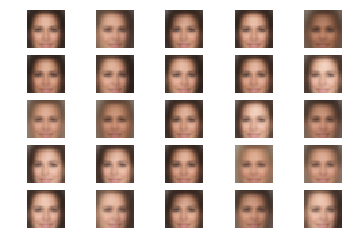

Epoch 261, train_loss: 1418.166260, running_time: 7
Epoch 262, train_loss: 1418.187256, running_time: 7
Epoch 263, train_loss: 1417.752319, running_time: 7
Epoch 264, train_loss: 1417.967163, running_time: 7
Epoch 265, train_loss: 1418.181885, running_time: 7
Epoch 266, train_loss: 1418.778442, running_time: 7
Epoch 267, train_loss: 1417.736938, running_time: 7
Epoch 268, train_loss: 1418.354370, running_time: 7
Epoch 269, train_loss: 1418.370850, running_time: 7
Epoch 270, train_loss: 1418.669556, running_time: 7


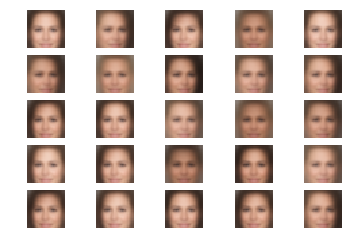

Epoch 271, train_loss: 1418.174316, running_time: 7
Epoch 272, train_loss: 1418.310181, running_time: 7
Epoch 273, train_loss: 1418.499390, running_time: 7
Epoch 274, train_loss: 1418.094238, running_time: 7
Epoch 275, train_loss: 1417.758057, running_time: 7
Epoch 276, train_loss: 1417.799316, running_time: 7
Epoch 277, train_loss: 1418.063965, running_time: 7
Epoch 278, train_loss: 1417.754639, running_time: 7
Epoch 279, train_loss: 1417.782715, running_time: 7
Epoch 280, train_loss: 1417.946777, running_time: 7


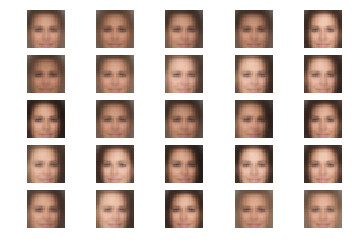

Epoch 281, train_loss: 1418.035645, running_time: 7
Epoch 282, train_loss: 1418.215698, running_time: 7
Epoch 283, train_loss: 1417.933960, running_time: 7
Epoch 284, train_loss: 1417.797485, running_time: 7
Epoch 285, train_loss: 1417.904175, running_time: 7
Epoch 286, train_loss: 1417.768799, running_time: 7
Epoch 287, train_loss: 1417.875854, running_time: 7
Epoch 288, train_loss: 1417.750366, running_time: 7
Epoch 289, train_loss: 1417.518677, running_time: 7
Epoch 290, train_loss: 1417.823242, running_time: 7


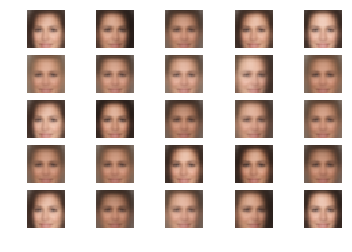

Epoch 291, train_loss: 1417.718262, running_time: 7
Epoch 292, train_loss: 1418.024658, running_time: 7
Epoch 293, train_loss: 1417.702148, running_time: 7
Epoch 294, train_loss: 1418.138062, running_time: 7
Epoch 295, train_loss: 1417.511353, running_time: 7
Epoch 296, train_loss: 1417.604858, running_time: 7
Epoch 297, train_loss: 1417.852295, running_time: 7
Epoch 298, train_loss: 1418.131104, running_time: 7
Epoch 299, train_loss: 1417.662964, running_time: 7
Epoch 300, train_loss: 1417.579956, running_time: 7


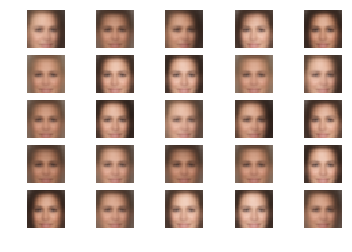

Epoch 301, train_loss: 1417.646240, running_time: 7
Epoch 302, train_loss: 1417.840820, running_time: 7
Epoch 303, train_loss: 1417.713257, running_time: 7
Epoch 304, train_loss: 1418.196289, running_time: 7
Epoch 305, train_loss: 1418.372437, running_time: 7
Epoch 306, train_loss: 1417.831055, running_time: 7
Epoch 307, train_loss: 1417.650635, running_time: 7
Epoch 308, train_loss: 1417.760620, running_time: 7
Epoch 309, train_loss: 1417.482300, running_time: 7
Epoch 310, train_loss: 1417.709229, running_time: 7


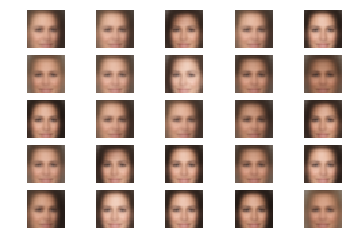

Epoch 311, train_loss: 1417.444092, running_time: 7
Epoch 312, train_loss: 1417.453369, running_time: 7
Epoch 313, train_loss: 1417.575684, running_time: 7
Epoch 314, train_loss: 1417.133667, running_time: 7
Epoch 315, train_loss: 1417.663940, running_time: 7
Epoch 316, train_loss: 1417.653320, running_time: 7
Epoch 317, train_loss: 1417.485474, running_time: 7
Epoch 318, train_loss: 1417.249268, running_time: 7
Epoch 319, train_loss: 1417.531616, running_time: 7
Epoch 320, train_loss: 1417.463013, running_time: 7


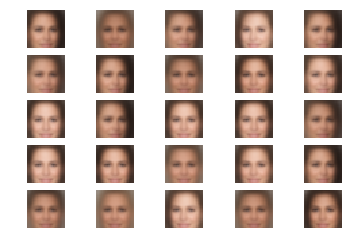

Epoch 321, train_loss: 1418.056030, running_time: 7
Epoch 322, train_loss: 1417.771118, running_time: 7
Epoch 323, train_loss: 1417.552124, running_time: 7
Epoch 324, train_loss: 1417.191406, running_time: 7
Epoch 325, train_loss: 1417.401733, running_time: 7
Epoch 326, train_loss: 1417.576782, running_time: 7
Epoch 327, train_loss: 1417.947266, running_time: 7
Epoch 328, train_loss: 1417.791016, running_time: 7
Epoch 329, train_loss: 1418.432983, running_time: 7
Epoch 330, train_loss: 1418.206909, running_time: 7


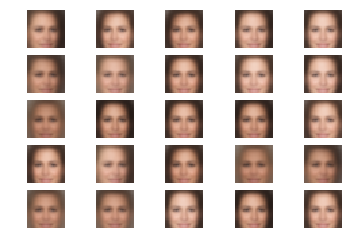

Epoch 331, train_loss: 1417.473755, running_time: 7
Epoch 332, train_loss: 1417.533691, running_time: 7
Epoch 333, train_loss: 1417.343018, running_time: 7
Epoch 334, train_loss: 1417.438843, running_time: 7
Epoch 335, train_loss: 1417.277588, running_time: 7
Epoch 336, train_loss: 1417.491211, running_time: 7
Epoch 337, train_loss: 1417.447388, running_time: 7
Epoch 338, train_loss: 1417.336060, running_time: 7
Epoch 339, train_loss: 1417.507568, running_time: 7
Epoch 340, train_loss: 1417.361084, running_time: 7


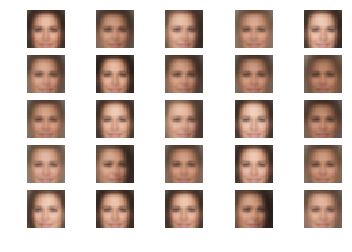

Epoch 341, train_loss: 1417.324585, running_time: 7
Epoch 342, train_loss: 1416.922607, running_time: 7
Epoch 343, train_loss: 1417.131104, running_time: 7
Epoch 344, train_loss: 1417.383789, running_time: 7
Epoch 345, train_loss: 1417.555298, running_time: 7
Epoch 346, train_loss: 1417.024170, running_time: 7
Epoch 347, train_loss: 1417.167603, running_time: 7
Epoch 348, train_loss: 1417.592285, running_time: 7
Epoch 349, train_loss: 1417.679688, running_time: 7
Epoch 350, train_loss: 1417.507568, running_time: 7


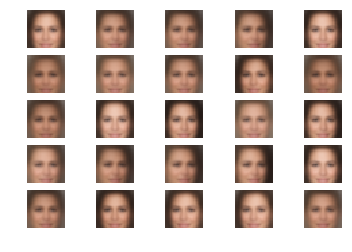

Epoch 351, train_loss: 1417.232056, running_time: 7
Epoch 352, train_loss: 1417.274902, running_time: 7
Epoch 353, train_loss: 1416.972778, running_time: 7
Epoch 354, train_loss: 1417.010254, running_time: 7
Epoch 355, train_loss: 1417.179688, running_time: 7
Epoch 356, train_loss: 1417.302002, running_time: 7
Epoch 357, train_loss: 1417.024658, running_time: 7
Epoch 358, train_loss: 1417.062256, running_time: 7
Epoch 359, train_loss: 1417.234741, running_time: 7
Epoch 360, train_loss: 1417.104370, running_time: 7


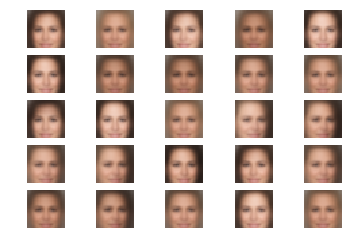

Epoch 361, train_loss: 1417.760620, running_time: 7
Epoch 362, train_loss: 1417.170288, running_time: 7
Epoch 363, train_loss: 1417.717651, running_time: 7
Epoch 364, train_loss: 1416.954956, running_time: 7
Epoch 365, train_loss: 1417.581909, running_time: 7
Epoch 366, train_loss: 1417.511353, running_time: 7
Epoch 367, train_loss: 1417.124146, running_time: 7
Epoch 368, train_loss: 1417.116699, running_time: 7
Epoch 369, train_loss: 1416.848999, running_time: 7
Epoch 370, train_loss: 1417.224609, running_time: 7


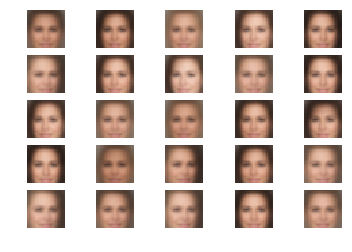

Epoch 371, train_loss: 1416.714111, running_time: 7
Epoch 372, train_loss: 1416.770874, running_time: 7
Epoch 373, train_loss: 1417.188110, running_time: 7
Epoch 374, train_loss: 1417.644287, running_time: 7
Epoch 375, train_loss: 1418.303711, running_time: 7
Epoch 376, train_loss: 1418.075317, running_time: 7
Epoch 377, train_loss: 1417.484863, running_time: 7
Epoch 378, train_loss: 1416.961792, running_time: 7
Epoch 379, train_loss: 1416.544189, running_time: 7
Epoch 380, train_loss: 1417.453247, running_time: 7


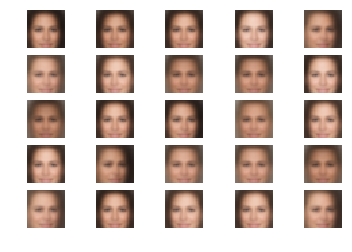

Epoch 381, train_loss: 1417.709595, running_time: 7
Epoch 382, train_loss: 1416.888184, running_time: 7
Epoch 383, train_loss: 1416.890991, running_time: 7
Epoch 384, train_loss: 1416.726440, running_time: 7
Epoch 385, train_loss: 1416.785278, running_time: 7
Epoch 386, train_loss: 1417.055542, running_time: 7
Epoch 387, train_loss: 1416.983887, running_time: 7
Epoch 388, train_loss: 1416.468750, running_time: 7
Epoch 389, train_loss: 1416.559082, running_time: 7
Epoch 390, train_loss: 1417.028931, running_time: 7


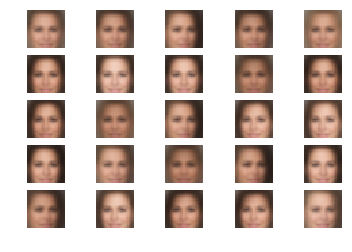

Epoch 391, train_loss: 1416.550049, running_time: 7
Epoch 392, train_loss: 1416.670898, running_time: 7
Epoch 393, train_loss: 1416.738770, running_time: 7
Epoch 394, train_loss: 1417.215698, running_time: 7
Epoch 395, train_loss: 1417.191528, running_time: 7
Epoch 396, train_loss: 1416.993652, running_time: 7
Epoch 397, train_loss: 1417.161865, running_time: 7
Epoch 398, train_loss: 1417.612549, running_time: 7
Epoch 399, train_loss: 1417.252319, running_time: 7
Epoch 400, train_loss: 1416.842407, running_time: 7


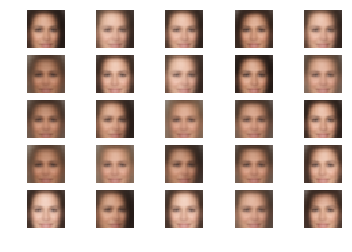

Epoch 401, train_loss: 1416.779175, running_time: 7
Epoch 402, train_loss: 1417.116089, running_time: 7
Epoch 403, train_loss: 1417.185669, running_time: 7
Epoch 404, train_loss: 1417.374878, running_time: 7
Epoch 405, train_loss: 1418.151978, running_time: 7
Epoch 406, train_loss: 1417.189331, running_time: 7
Epoch 407, train_loss: 1417.866577, running_time: 7
Epoch 408, train_loss: 1416.890869, running_time: 7
Epoch 409, train_loss: 1416.824829, running_time: 7
Epoch 410, train_loss: 1416.679077, running_time: 7


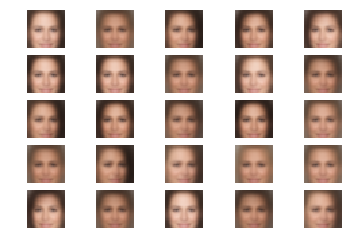

Epoch 411, train_loss: 1416.635132, running_time: 7
Epoch 412, train_loss: 1417.677368, running_time: 7
Epoch 413, train_loss: 1417.576172, running_time: 7
Epoch 414, train_loss: 1416.527832, running_time: 7
Epoch 415, train_loss: 1416.465576, running_time: 7
Epoch 416, train_loss: 1416.373291, running_time: 7
Epoch 417, train_loss: 1416.899658, running_time: 7
Epoch 418, train_loss: 1417.264038, running_time: 7
Epoch 419, train_loss: 1418.343750, running_time: 7
Epoch 420, train_loss: 1416.687744, running_time: 7


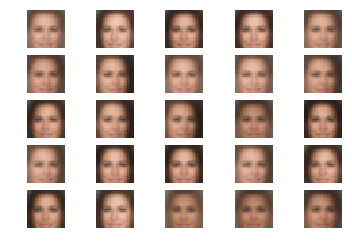

Epoch 421, train_loss: 1416.797852, running_time: 7
Epoch 422, train_loss: 1417.634888, running_time: 7
Epoch 423, train_loss: 1417.514038, running_time: 7
Epoch 424, train_loss: 1416.754272, running_time: 7
Epoch 425, train_loss: 1417.254639, running_time: 7
Epoch 426, train_loss: 1416.775146, running_time: 7
Epoch 427, train_loss: 1416.665039, running_time: 7
Epoch 428, train_loss: 1416.669922, running_time: 7
Epoch 429, train_loss: 1417.169312, running_time: 7
Epoch 430, train_loss: 1416.939209, running_time: 7


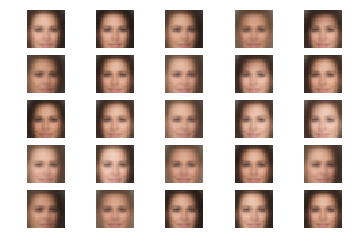

Epoch 431, train_loss: 1416.833252, running_time: 7
Epoch 432, train_loss: 1416.732422, running_time: 7
Epoch 433, train_loss: 1416.909302, running_time: 7
Epoch 434, train_loss: 1416.852173, running_time: 7
Epoch 435, train_loss: 1416.489136, running_time: 7
Epoch 436, train_loss: 1416.406860, running_time: 7
Epoch 437, train_loss: 1416.706055, running_time: 7
Epoch 438, train_loss: 1417.049927, running_time: 7
Epoch 439, train_loss: 1416.995239, running_time: 7
Epoch 440, train_loss: 1416.564697, running_time: 7


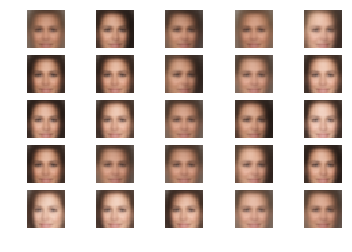

Epoch 441, train_loss: 1417.300659, running_time: 7
Epoch 442, train_loss: 1416.791016, running_time: 7
Epoch 443, train_loss: 1416.770996, running_time: 7
Epoch 444, train_loss: 1417.128296, running_time: 7
Epoch 445, train_loss: 1416.874146, running_time: 7
Epoch 446, train_loss: 1417.333252, running_time: 7
Epoch 447, train_loss: 1417.869385, running_time: 7
Epoch 448, train_loss: 1416.717285, running_time: 7
Epoch 449, train_loss: 1417.964355, running_time: 7
Epoch 450, train_loss: 1417.826294, running_time: 7


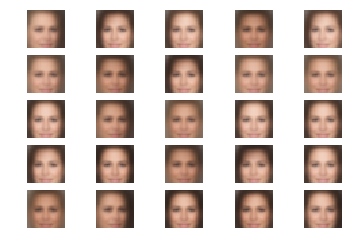

Epoch 451, train_loss: 1417.363892, running_time: 7
Epoch 452, train_loss: 1416.888916, running_time: 7
Epoch 453, train_loss: 1416.767700, running_time: 7
Epoch 454, train_loss: 1417.223999, running_time: 7
Epoch 455, train_loss: 1417.826782, running_time: 7
Epoch 456, train_loss: 1418.124390, running_time: 7
Epoch 457, train_loss: 1417.078979, running_time: 7
Epoch 458, train_loss: 1416.793945, running_time: 7
Epoch 459, train_loss: 1416.751465, running_time: 7
Epoch 460, train_loss: 1418.085815, running_time: 7


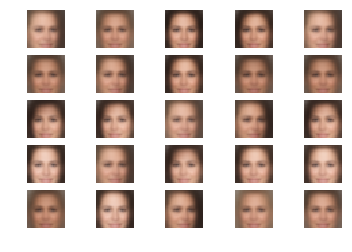

Epoch 461, train_loss: 1416.350342, running_time: 7
Epoch 462, train_loss: 1416.373657, running_time: 7
Epoch 463, train_loss: 1417.727417, running_time: 7
Epoch 464, train_loss: 1417.399536, running_time: 7
Epoch 465, train_loss: 1417.070801, running_time: 7
Epoch 466, train_loss: 1416.866699, running_time: 7
Epoch 467, train_loss: 1416.506592, running_time: 7
Epoch 468, train_loss: 1416.912842, running_time: 7
Epoch 469, train_loss: 1419.933350, running_time: 7
Epoch 470, train_loss: 1422.712524, running_time: 7


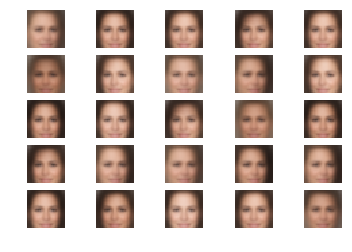

Epoch 471, train_loss: 1422.210327, running_time: 7
Epoch 472, train_loss: 1419.377441, running_time: 7
Epoch 473, train_loss: 1418.344604, running_time: 7
Epoch 474, train_loss: 1418.133301, running_time: 7
Epoch 475, train_loss: 1417.696655, running_time: 7
Epoch 476, train_loss: 1417.951782, running_time: 7
Epoch 477, train_loss: 1418.351685, running_time: 7
Epoch 478, train_loss: 1417.426514, running_time: 7
Epoch 479, train_loss: 1418.760010, running_time: 7
Epoch 480, train_loss: 1417.759644, running_time: 7


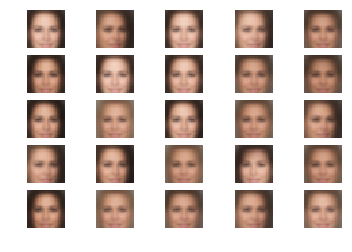

Epoch 481, train_loss: 1418.093140, running_time: 7
Epoch 482, train_loss: 1418.041992, running_time: 7
Epoch 483, train_loss: 1418.056885, running_time: 7
Epoch 484, train_loss: 1417.756348, running_time: 7
Epoch 485, train_loss: 1417.511353, running_time: 7
Epoch 486, train_loss: 1417.532593, running_time: 7
Epoch 487, train_loss: 1417.588867, running_time: 7
Epoch 488, train_loss: 1417.464966, running_time: 7
Epoch 489, train_loss: 1417.354980, running_time: 7
Epoch 490, train_loss: 1417.212280, running_time: 7


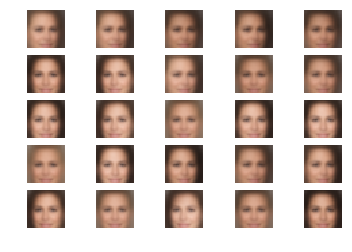

Epoch 491, train_loss: 1417.293213, running_time: 7
Epoch 492, train_loss: 1417.398926, running_time: 7
Epoch 493, train_loss: 1417.362183, running_time: 7
Epoch 494, train_loss: 1417.032227, running_time: 7
Epoch 495, train_loss: 1417.064575, running_time: 7
Epoch 496, train_loss: 1417.108398, running_time: 7
Epoch 497, train_loss: 1417.452026, running_time: 7
Epoch 498, train_loss: 1416.974854, running_time: 7
Epoch 499, train_loss: 1417.108032, running_time: 7


In [15]:
import time

with tf.Session(config=tf.ConfigProto(log_device_placement=True, allow_soft_placement = True)) as sess:

    sess.run(init)    
    train_writer = tf.summary.FileWriter(log_dir)
    sess.run(iterator.initializer, feed_dict={data_placeholder: data})

    for epoch in range(params['num_epochs']):

        loss_total = []
        num_batches = int(num_inputs/params['batch_size']) + 1

        # train
        a = time.time()
        for batch_idx in range(num_batches):
            global_step = epoch * params['batch_size'] + batch_idx            
            batch = sess.run(next_batch)
             
            feed_dict = {model.train_input: batch}
            _, train_loss_value, train_summary = sess.run([train_op, train_loss, train_summary_op], feed_dict=feed_dict)
            loss_total.append(train_loss_value)
            train_writer.add_summary(train_summary, global_step=global_step)

        b = time.time()

        #display epoch result
        train_loss_epoch = np.array(loss_total).mean()     
        print("Epoch %d, train_loss: %2f, running_time: %d" %(epoch, train_loss_epoch, b-a))

        if epoch % 10 == 0:
            gen_op = model.generate()
            z = np.random.uniform(-1, 1, size=(params['gen_size'], params['latent_dim']))
            #print(z.shape)
            gen_feed_dict = {model.gen_input: z}
            output_images = sess.run(gen_op, feed_dict=gen_feed_dict)
            display_images(output_images)